## Climate Analysis and Exploration

In [1]:
#dependencies and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

#Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine, inspect, func

In [2]:
#create engine connection to sqlite database 
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [3]:
#reflect database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurements', 'stations']

In [4]:
#map "measurements" class
Measurements = Base.classes.measurements

In [5]:
#create a session
session = Session(engine)

In [6]:
#check "measurements" data
engine.execute('Select * from measurements limit 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65),
 (2, 'USC00519397', '2010-01-02', 0.0, 63),
 (3, 'USC00519397', '2010-01-03', 0.0, 74),
 (4, 'USC00519397', '2010-01-04', 0.0, 76),
 (5, 'USC00519397', '2010-01-07', 0.06, 70)]

### Precipitation Analysis 

In [7]:
#check columns in "measurements" class
inspector = inspect(engine)
columns = inspector.get_columns("measurements")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station VARCHAR(45)
date VARCHAR(45)
prcp FLOAT
tobs INTEGER


In [8]:
#create query to retrieve 12 months of precipitation data
prcp_by_dates = session.query(Measurements.date, Measurements.prcp)\
                .filter(Measurements.date.between("2016-08-24", "2017-08-23"))\
                .group_by(Measurements.date)\
                .order_by(Measurements.date).all()
#prcp_by_dates

In [9]:
#load query onto pandas dataframe
prcp_df = pd.DataFrame(prcp_by_dates, columns=["date", "prcp"])
prcp_df.set_index("date", inplace=True)
prcp_df.head()

,prcp
date,
2016-08-24,1.45
2016-08-25,0.11
2016-08-26,0.01
2016-08-27,0.12
2016-08-28,2.07


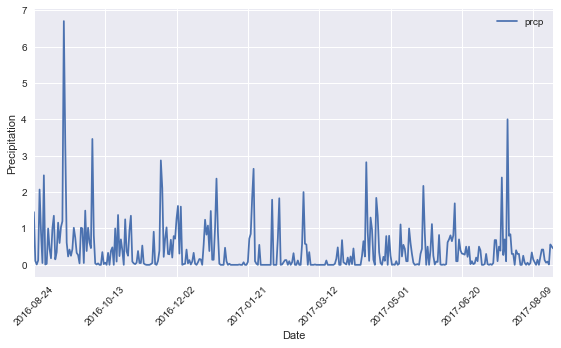

In [10]:
#reset index
prcp_df.reset_index(inplace=True, drop=False)

#create bar chart to display data
sns.set()
prcp_df.plot("date", "prcp", rot=45, figsize=(8,5))
plt.ylabel("Precipitation")
plt.xlabel("Date")
plt.tight_layout()
plt.savefig("Date_v_Precipitation.png")
plt.show()

In [11]:
#summary of statistics for precipitation data
prcp_df.describe()

,prcp
count,365.000000
mean,0.413753
std,0.691290
min,0.000000
25%,0.000000
50%,0.120000
75%,0.550000
max,6.700000


### Station Analysis

In [12]:
#map "stations" class
Stations = Base.classes.stations

In [13]:
#check columns in "stations" class
inspector = inspect(engine)
columns = inspector.get_columns("stations")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station VARCHAR(45)
name VARCHAR(45)
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
#create query to find total number of stations
total_stations = session.query(func.count(Stations.station)).one()
print("There are " + str(total_stations[0]) + " total stations in Hawaii.")

There are 9 total stations in Hawaii.


In [15]:
#create query to find most active station
#join on station to get name of most active station
sel2 = [Measurements.station,
        func.count(Measurements.station),
        Stations.station, 
        Stations.name]
same_station = session.query(Measurements.station, func.count(Measurements.station), Stations.station, Stations.name)\
               .filter(Measurements.station == Stations.station)\
               .group_by(Measurements.station)\
               .order_by(func.count(Measurements.station).desc()).all()
same_station[0] #return first value

print(f"The most active station is {same_station[0][0]} or {same_station[0][3]} with {same_station[0][1]} recorded observations.")

The most active station is USC00519281 or WAIHEE 837.5, HI US with 2772 recorded observations.


In [16]:
#create query to retrieve 12 months of temperature observation data(tobs)
#filter by station with the highest number of observations 
most_active_tobs = session.query(Measurements.tobs)\
                   .filter(Measurements.date.between("2016-08-24", "2017-08-23"))\
                   .filter(Measurements.station == same_station[0][0])\
                   .order_by(Measurements.date).all()
#most_active_tobs

In [17]:
#unpack tuple from most_active_tobs
tobs = [float(x[0]) for x in most_active_tobs]

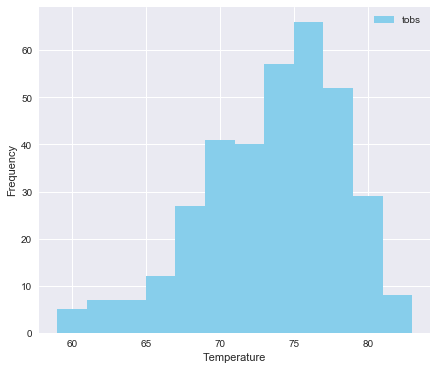

In [18]:
#create histogram of data
plt.figure(figsize=(7,6))
plt.hist(tobs, bins=12, facecolor="skyblue", label="tobs")
plt.xlabel("Temperature")
plt.ylabel("Frequency")

plt.legend()
plt.savefig("Temp_v_Frequency.png")
plt.show()

### Temperature Analysis 

In [19]:
#create function "calc_temps"
def calc_temps(start_date, end_date):
    calcs = session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs))\
            .filter(Measurements.date.between(start_date, end_date)).one()
    return calcs

In [20]:
#test function - random vacation days from 4/1/17-4/11/17
vacay = calc_temps("2017-04-01", "2017-04-11")
vacay_min = vacay[0]
vacay_avg = vacay[1]
vacay_max = vacay[2]

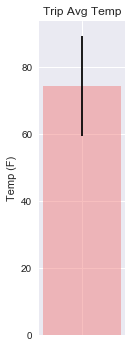

In [21]:
#create bar chart of average temperature 
x=[""]

sns.set()
plt.figure(figsize=(2,5))
plt.bar(x, vacay_avg, facecolor="lightcoral", 
        width=0.25, alpha=0.5,
        yerr=(vacay_max-vacay_min))
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.savefig("Trip_Avg_Temp.png")
plt.show()